# Load Dataset with Kaggle API

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import zipfile
import os
from kaggle.api.kaggle_api_extended import KaggleApi
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Initialize the Kaggle API
api = KaggleApi()
api.authenticate()

In [5]:
# Download the dataset
dataset = 'kanchana1990/e-commerce-furniture-dataset-2024'
api.dataset_download_files(dataset, path='e-commerce-furniture-dataset-2024', unzip=False)

In [6]:
# Unzip the dataset
with zipfile.ZipFile("e-commerce-furniture-dataset-2024/e-commerce-furniture-dataset-2024.zip",'r') as file:
    file.extractall("e-commerce-furniture-dataset-2024")

In [7]:
# List the files in the unzipped directory to find the correct csv file name
print(os.listdir("e-commerce-furniture-dataset-2024"))

['e-commerce-furniture-dataset-2024.zip', 'ecommerce_furniture_dataset_2024.csv']


In [8]:
# Load the data
df = pd.read_csv("e-commerce-furniture-dataset-2024/ecommerce_furniture_dataset_2024.csv")
df

,productTitle,originalPrice,price,sold,tagText
0,Dresser For Bedroom With 9 Fabric Drawers Ward...,NaN,$46.79,600,Free shipping
1,Outdoor Conversation Set 4 Pieces Patio Furnit...,NaN,$169.72,0,Free shipping
2,Desser For Bedroom With 7 Fabric Drawers Organ...,$78.4,$39.46,7,Free shipping
3,"Modern Accent Boucle Chair,Upholstered Tufted ...",NaN,$111.99,0,Free shipping
4,Small Unit Simple Computer Desk Household Wood...,$48.82,$21.37,1,Free shipping
...,...,...,...,...,...
1995,Modern TV Stand Entertainment Center with Two ...,NaN,$72.49,8,Free shipping
1996,"Large Wardrobe Armoire Closet with 3 Doors, Fr...",NaN,$276.65,2,Free shipping
1997,"Velvet Futon Sofa Bed, 73-inch Sleeper Couch w...",NaN,$196.44,10,Free shipping
1998,Furniture Acrylic Coffee Table Transparent Liv...,NaN,$228.18,0,Free shipping


# Data Cleaning

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   productTitle   2000 non-null   object
 1   originalPrice  487 non-null    object
 2   price          2000 non-null   object
 3   sold           2000 non-null   int64 
 4   tagText        1997 non-null   object
dtypes: int64(1), object(4)
memory usage: 78.3+ KB


In [10]:
df.shape

(2000, 5)

In [11]:
# Check for duplicates
df.duplicated().sum()

94

In [12]:
# Remove duplicates
df.drop_duplicates(inplace=True)

In [13]:
# Re-checking for duplicates
df.duplicated().sum()

0

In [14]:
# Checking for missing values
df.isnull().sum()

productTitle        0
originalPrice    1436
price               0
sold                0
tagText             2
dtype: int64

In [15]:
# Filled na values in originalPrice column with values in price column as no discounts were applied
df['originalPrice'].fillna(df['price'], inplace=True)
df['tagText'].fillna('Free shipping', inplace=True)

# Verify changes
df.isnull().sum()

productTitle     0
originalPrice    0
price            0
sold             0
tagText          0
dtype: int64

In [16]:
# Rename columns
df.rename({'productTitle':'product title', 'originalPrice':'original price','sold':'quantity sold','tagText':'cost of shipping'},axis=1,inplace=True)

In [17]:
# Remove dollar sign from price column
df['price'] = df['price'].str.replace('$','',).str.replace(',','')
# Change price column from string to float
df['price'] = df['price'].astype('float')

In [18]:
# Remove dollar sign from original price column
df['original price'] = df['original price'].str.replace('$','',).str.replace(',','')
# Change original price data type from string to float
df['original price'] = df['original price'].astype('float')

In [19]:
# Remove'+Shipping: $' from the cost of shipping column and convert 'Free shipping' to 0
df['cost of shipping'] = df['cost of shipping'].str.replace('Free shipping', '0')
df['cost of shipping'] = df['cost of shipping'].str.replace('+Shipping: $', '')
df['cost of shipping'] = df['cost of shipping'].str.replace(',', '')

# Convert cost of shipping column from string to float
df['cost of shipping'] = df['cost of shipping'].astype('float')

In [20]:
# Create new column for revenue
df['total revenue'] = df['price'] * df['quantity sold']

# Create new column for discount
df['discount'] = df['original price'] - df['price']

# Create new column for discount percentage
df['discount percentage'] = (df['discount'] / df['original price']) * 100

In [21]:
# Calculate gross profit and margin
df['gross profit'] = df['total revenue'] - (df['original price'] * df['quantity sold'])
df['gross profit margin'] = np.where(df['total revenue'] !=0, (df['gross profit'] / df['total revenue']) * 100, 0)

In [22]:
# Calculate net profit
df['net profit'] = df['total revenue'] - (df['original price'] * df['quantity sold']) - (df['cost of shipping'] * df['quantity sold'])
# Calculate net profit margin
df['net profit margin'] = np.where(df['total revenue'] !=0, (df['net profit'] / df['total revenue']) * 100, 0)

In [23]:
# Function to extract product type from the title
def extract_product_type(title):
    keywords = [
        'Chair', 'Table', 'Dresser', 'Sofa', 'Bed', 'Dining Set', 
        'Desk', 'Cabinet', 'Shelf', 'Stool', 'Bench', 'Wardrobe', 
        'Bookshelf', 'Nightstand', 'Couch', 'Armchair', 'Recliner',
        'Ottoman', 'Vanity', 'Coffee Table', 'End Table', 'Side Table',
        'Entertainment Center', 'TV Stand', 'Loveseat', 'Chaise',
        'Sectional', 'Buffet', 'Hutch', 'Bar Stool', 'Counter Stool',
        'Futon', 'Daybed', 'Headboard', 'Footboard', 'Pantry', 'Credenza',
        'Console Table', 'Filing Cabinet', 'Accent Table', 'Hall Tree',
        'Murphy Bed', 'Chaise Lounge', 'Chaise Longue', 'Chiffonier',
        'Chest of Drawers', 'China Cabinet', 'Curio Cabinet', 'Baker’s Rack',
        'Piano Bench', 'Storage Bench', 'Swivel Chair', 'Wingback Chair',
        'Rocking Chair', 'Lift Chair', 'Glider', 'Bean Bag'
    ]
    for keyword in keywords:
        if keyword.lower() in title.lower():
            return keyword
    return 'Other'

# Function to extract brand from the title
def extract_brand(title):
    brand_patterns = [
        'Christopher Knight Home', 'Project 62', 'Eco Dream', 
        'Room & Joy', 'Captiva Designs', 'Ikea', 'Ashley Furniture', 
        'Home Depot', 'Wayfair', 'Herman Miller', 'Steelcase', 
        'Havertys', 'West Elm', 'Pottery Barn', 'La-Z-Boy'
    ]
    for brand in brand_patterns:
        if brand.lower() in title.lower():
            return brand
    return 'Unknown'

In [24]:
# Apply the functions to create new columns
df['product type'] = df['product title'].apply(extract_product_type)
df['brand'] = df['product title'].apply(extract_brand)

In [25]:
# Creating bins for original price
original_price_bins = [0, 100, 500, 1000, float('inf')]
original_price_labels = ['Low', 'Medium', 'High', 'Very High']
df['original price bin'] = pd.cut(df['original price'], bins=original_price_bins, labels=original_price_labels, right=False)

In [26]:
# Creating bins for price
price_bins = [0, 100, 500, 1000, float('inf')]
price_labels = ['Low', 'Medium', 'High', 'Very High']
df['price bin'] = pd.cut(df['price'], bins=price_bins, labels=price_labels, right=False)

In [27]:
# Creating bins for discount percentage
discount_bins = [-float('inf'), 0, 10, 25, 50, float('inf')]
discount_labels = ['No Discount', 'Low Discount', 'Medium Discount', 'High Discount', 'Very High Discount']
df['discount percentage bin'] = pd.cut(df['discount percentage'], bins=discount_bins, labels=discount_labels, right=False)

In [28]:
# Creating bins for cost of shipping
shipping_cost_bins = [0, 5, 15, float('inf')]
shipping_cost_labels = ['Low', 'Medium', 'High']
df['shipping cost bin'] = pd.cut(df['cost of shipping'], bins=shipping_cost_bins, labels=shipping_cost_labels, right=False).cat.add_categories(['Free'])
df['shipping cost bin'].fillna('Free', inplace=True)

In [29]:
# Creating sales category based on quantity sold
df['sales category'] = pd.cut(df['quantity sold'], bins=[-1,0,10, float('inf')], labels=['No Sales', 'Low Sales', 'High Sales'])

In [30]:
# Creating column for revenue per unit
df['revenue per unit'] = df['total revenue'] / df['quantity sold']
# Handling rows that divide by zero
df['revenue per unit'].fillna(0, inplace=True)

In [31]:
# Creating a column to see the cost per unit
df['cost per unit'] = (df['original price'] + df['cost of shipping'] / df['quantity sold'])
# Handling rows that are divided by zero
df['cost per unit'].fillna(0, inplace=True)

In [32]:
# Creating a column for profit category based on profit margins
df['profit category'] = pd.cut(df['net profit margin'], bins=[-float('inf'), 0, 20, 50, float('inf')], labels=['Loss', 'Low Profit', 'Medium Profit', 'High Profit'])

# Visualizations

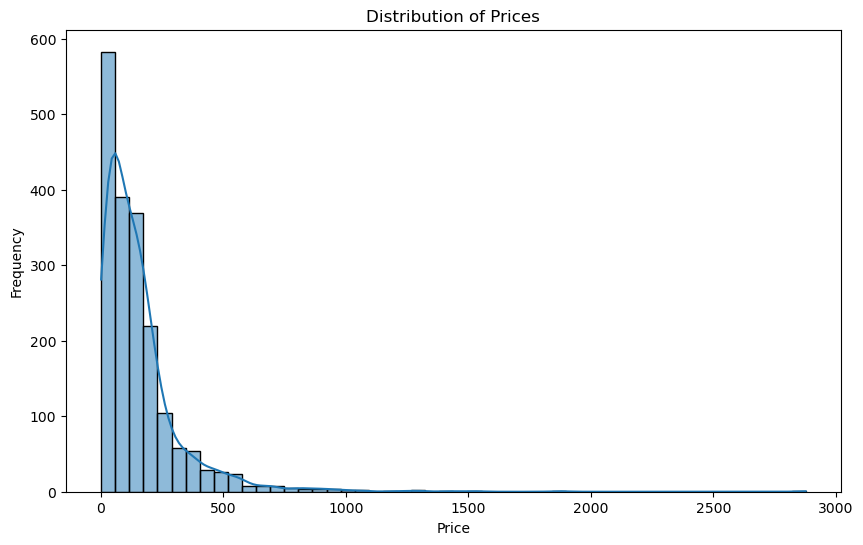

In [33]:
# Price Distribution of prices and quantities sold
plt.figure(figsize=(10,6))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

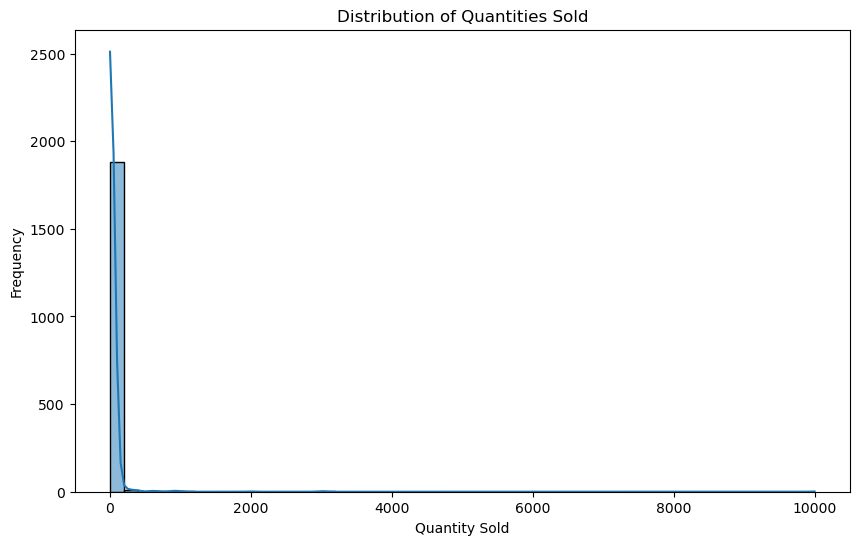

In [34]:
# Quantities Sold
plt.figure(figsize=(10,6))
sns.histplot(df['quantity sold'], bins=50, kde=True)
plt.title('Distribution of Quantities Sold')
plt.xlabel('Quantity Sold')
plt.ylabel('Frequency')
plt.show()

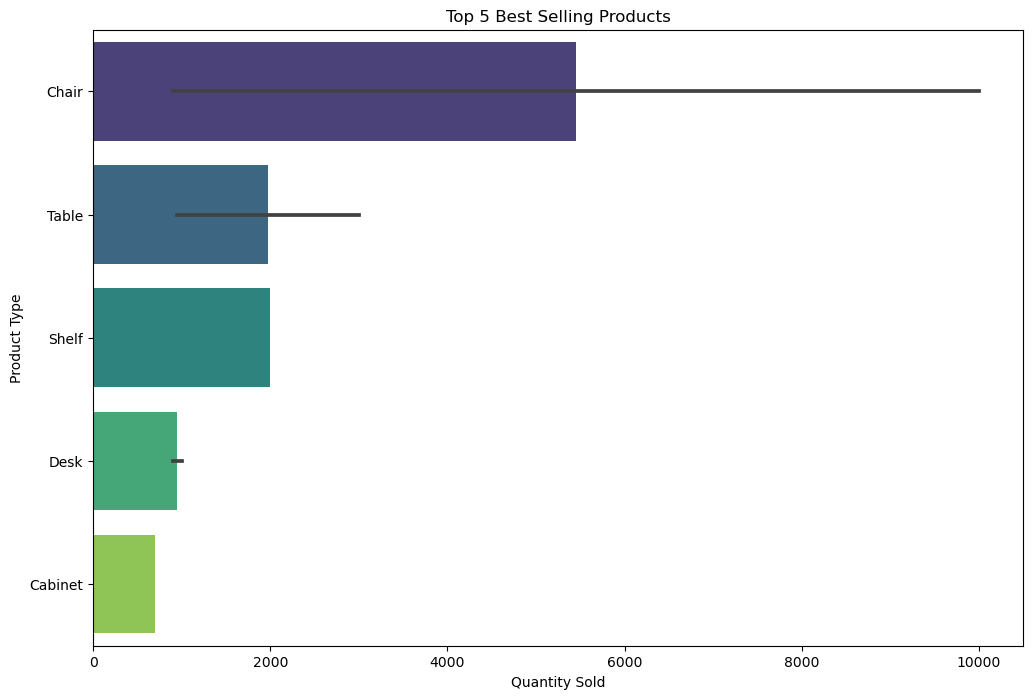

In [41]:
# Top 5 Best Selling Products and their contribution to total revenue
top_sold = df.sort_values(by='quantity sold', ascending=False).head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x='quantity sold', y='product type', data=top_sold, palette='viridis')
plt.title('Top 5 Best Selling Products')
plt.xlabel('Quantity Sold')
plt.ylabel('Product Type')
plt.show()

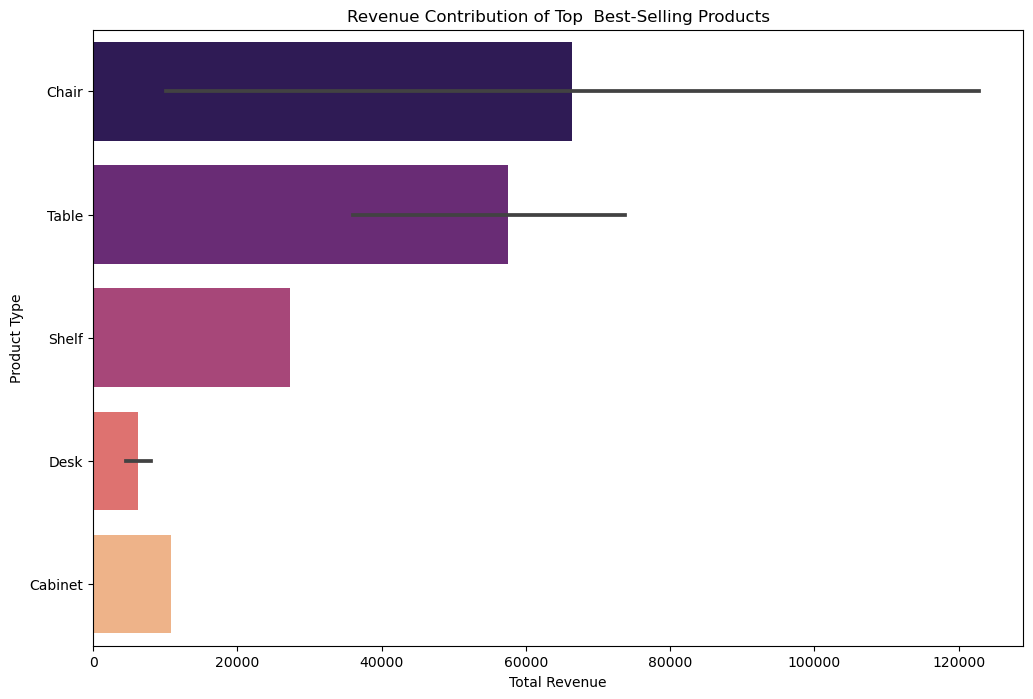

In [40]:
# Revenue contributino of Top 5 Best Selling Products
plt.figure(figsize=(12, 8))
sns.barplot(x='total revenue', y='product type', data=top_sold, palette='magma')
plt.title('Revenue Contribution of Top  Best-Selling Products')
plt.xlabel('Total Revenue')
plt.ylabel('Product Type')
plt.show()

In [43]:
# Aggregating similar products under common categories
df['product category'] = df['product title'].apply(lambda x: ' '.join(x.split()[:2]))

# Creating a new column combining brand and productType
df['brand product'] = df['brand'] + ' ' + df['product type']

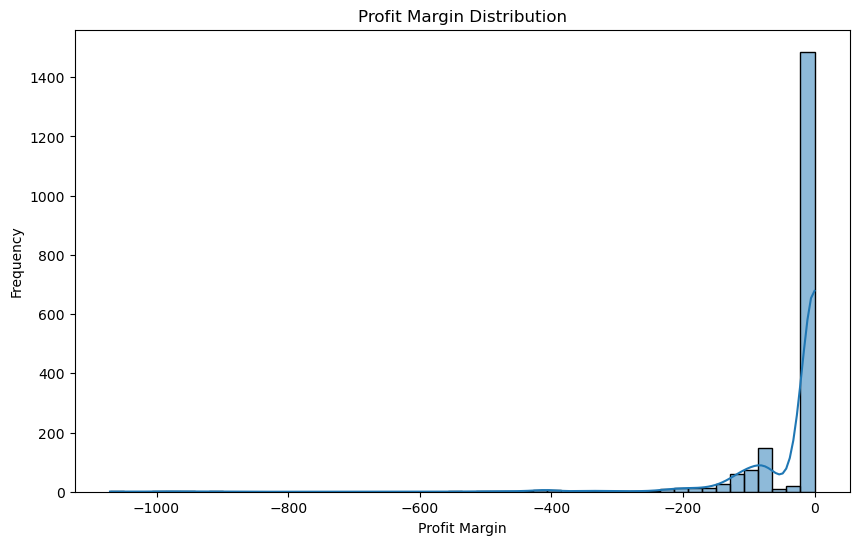

In [44]:
# Profit Margin Distribution
plt.figure(figsize=(10,6))
sns.histplot(df['gross profit margin'], bins=50, kde=True)
plt.title('Profit Margin Distribution')
plt.xlabel('Profit Margin')
plt.ylabel('Frequency')
plt.show()

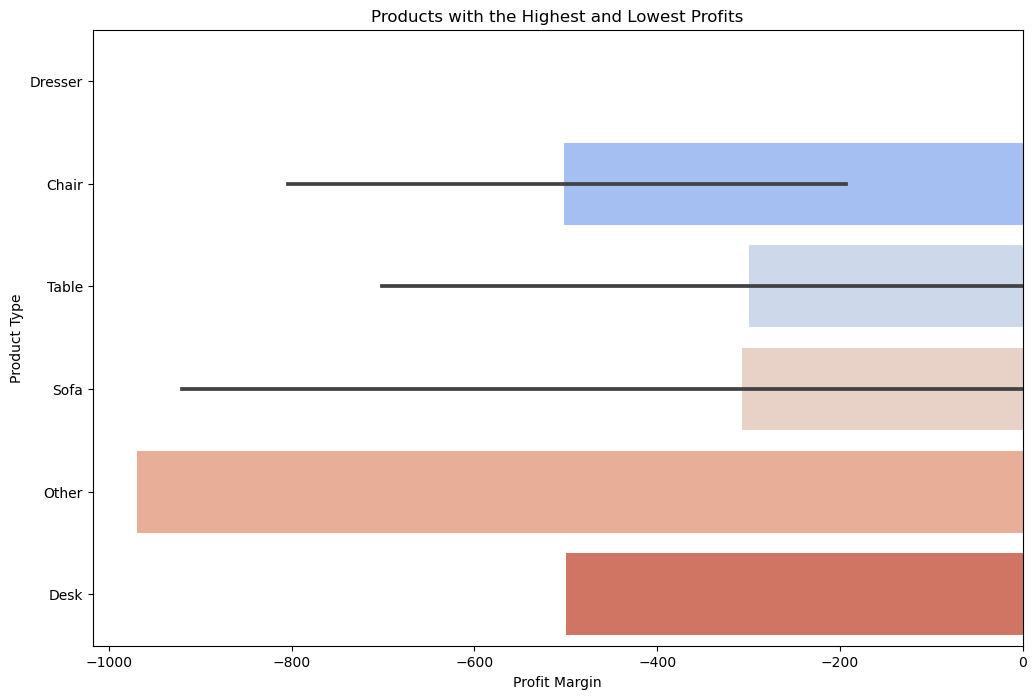

In [45]:
# Products with the Highest and Lowest Profits
highest_profits = df.nlargest(10, 'gross profit margin')
lowest_profits = df.nsmallest(10, 'gross profit margin')

plt.figure(figsize=(12, 8))
sns.barplot(x='gross profit margin', y='product type', data=pd.concat([highest_profits, lowest_profits]), palette='coolwarm')
plt.title('Products with the Highest and Lowest Profits')
plt.xlabel('Profit Margin')
plt.ylabel('Product Type')
plt.show()

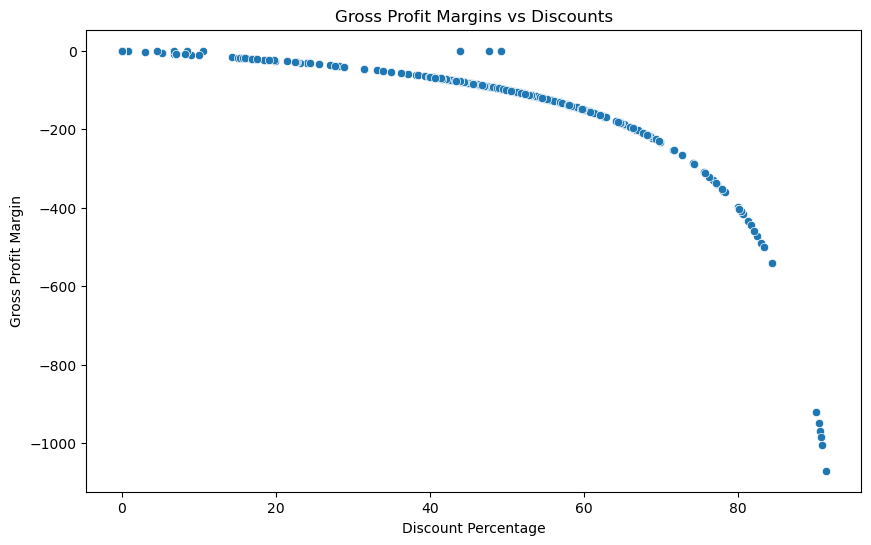

In [46]:
# Impact of Discounts and Costs on Profit Margins
plt.figure(figsize=(10,6))
sns.scatterplot(x='discount percentage', y='gross profit margin', data=df)
plt.title('Gross Profit Margins vs Discounts')
plt.xlabel('Discount Percentage')
plt.ylabel('Gross Profit Margin')
plt.show()

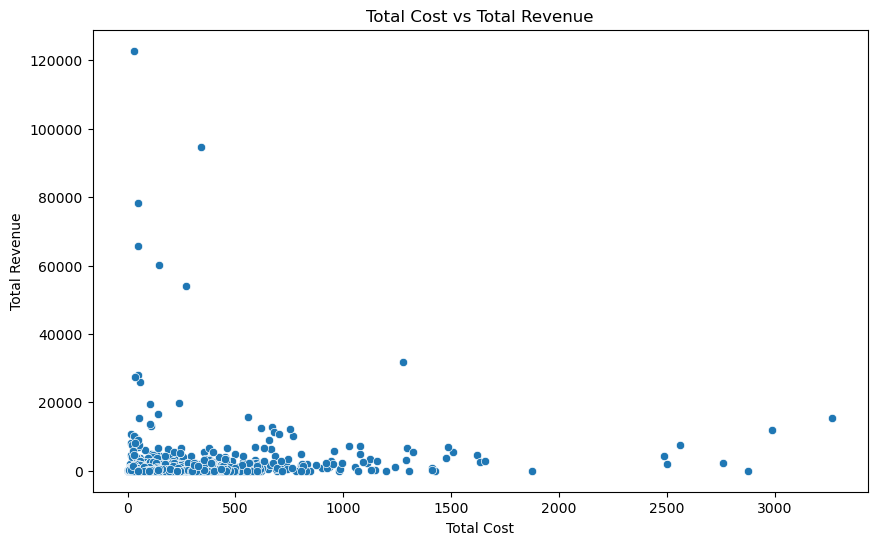

In [47]:
# Total Cost vs Total Revenue
plt.figure(figsize=(10,6))
sns.scatterplot(x=df['original price'] + df['cost of shipping'], y='total revenue', data=df)
plt.title('Total Cost vs Total Revenue')
plt.xlabel('Total Cost')
plt.ylabel('Total Revenue')
plt.show()

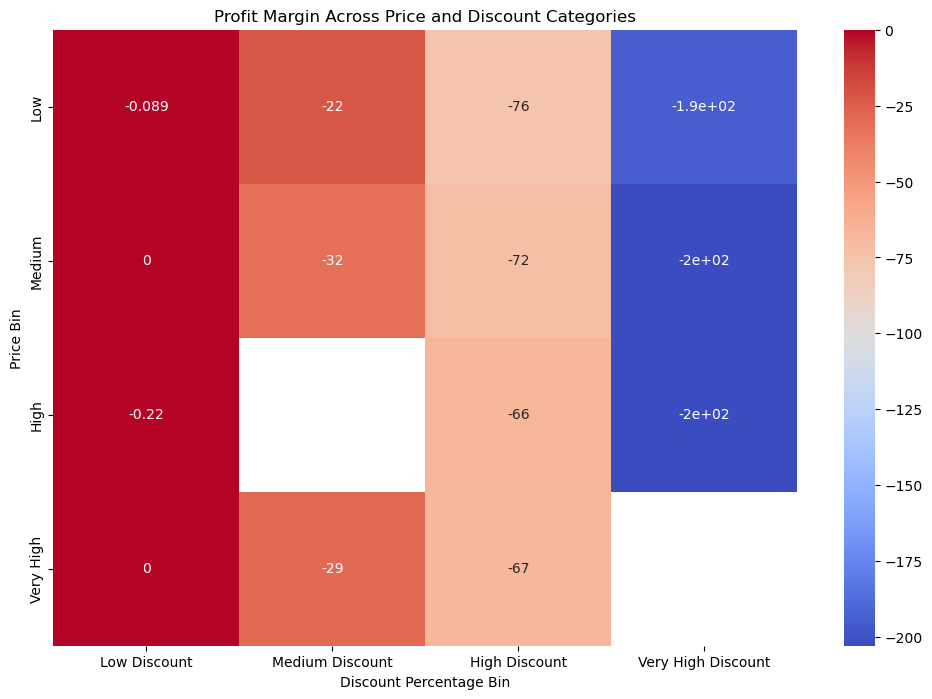

In [48]:
# Performance Metrics Across Bins and Categories
plt.figure(figsize=(12, 8))
sns.heatmap(df.pivot_table(index='price bin', columns='discount percentage bin', values='gross profit margin', aggfunc='mean'), annot=True, cmap='coolwarm')
plt.title('Profit Margin Across Price and Discount Categories')
plt.xlabel('Discount Percentage Bin')
plt.ylabel('Price Bin')
plt.show()

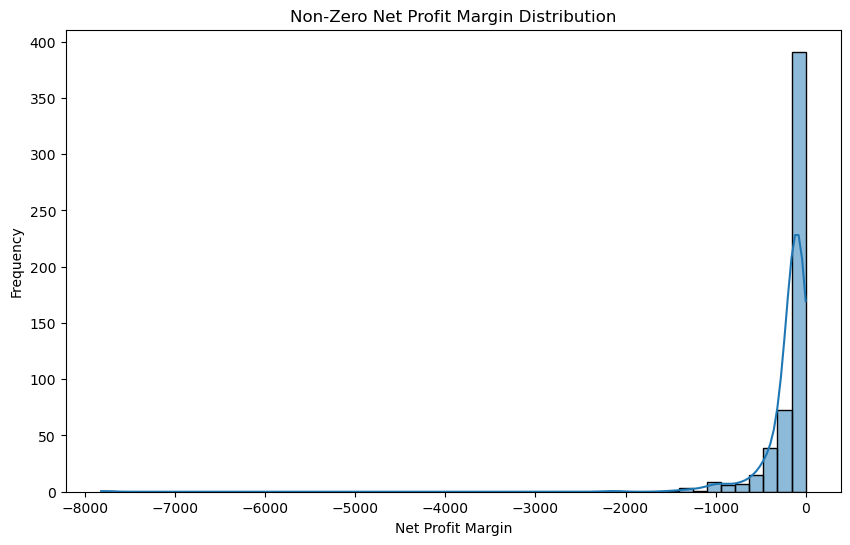

In [51]:
# Filter out zero values
non_zero_profit_margin = df[df['net profit margin'] != 0]
plt.figure(figsize=(10, 6))
sns.histplot(non_zero_profit_margin['net profit margin'], bins=50, kde=True)
plt.title('Non-Zero Net Profit Margin Distribution')
plt.xlabel('Net Profit Margin')
plt.ylabel('Frequency')
plt.show()

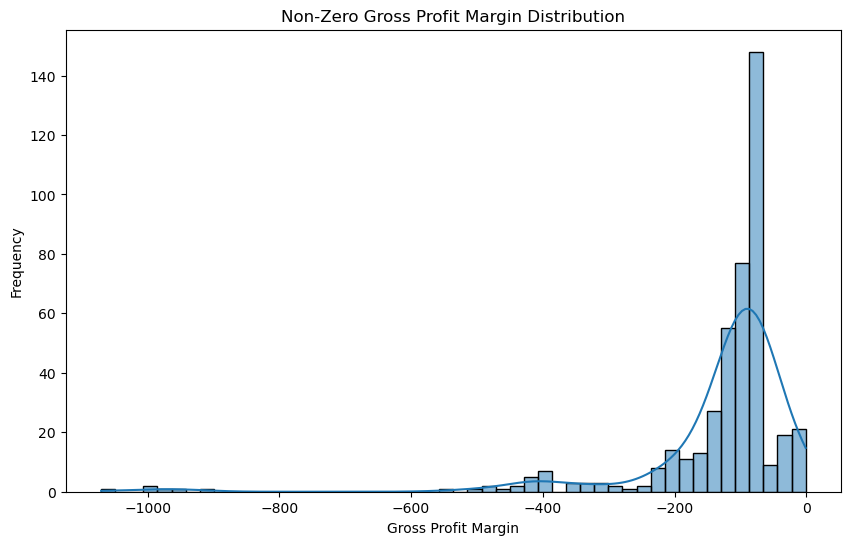

In [52]:
# Filter out zero values
non_zero_profit_margin = df[df['gross profit margin'] != 0]
plt.figure(figsize=(10, 6))
sns.histplot(non_zero_profit_margin['gross profit margin'], bins=50, kde=True)
plt.title('Non-Zero Gross Profit Margin Distribution')
plt.xlabel('Gross Profit Margin')
plt.ylabel('Frequency')
plt.show()

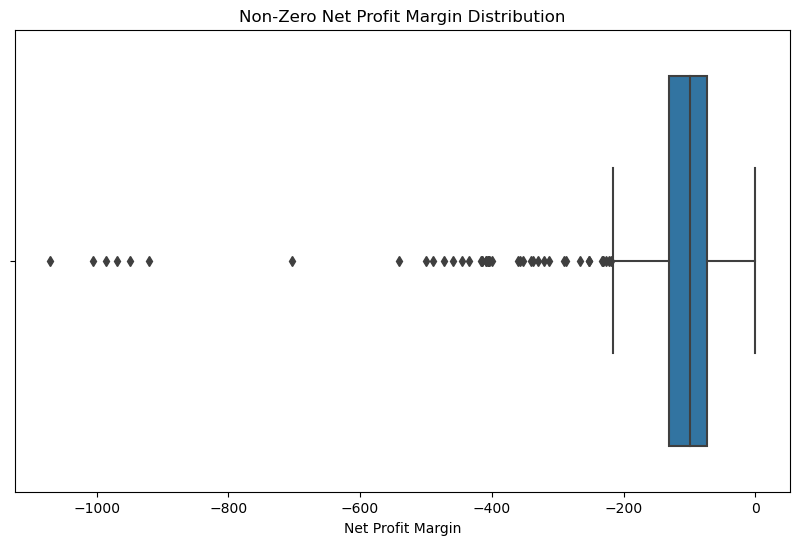

In [53]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=non_zero_profit_margin['net profit margin'])
plt.title('Non-Zero Net Profit Margin Distribution')
plt.xlabel('Net Profit Margin')
plt.show()

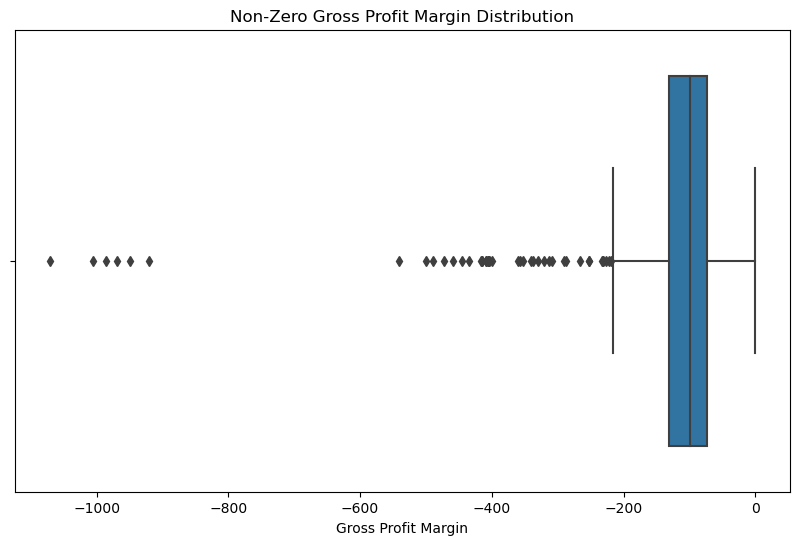

In [54]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=non_zero_profit_margin['gross profit margin'])
plt.title('Non-Zero Gross Profit Margin Distribution')
plt.xlabel('Gross Profit Margin')
plt.show()

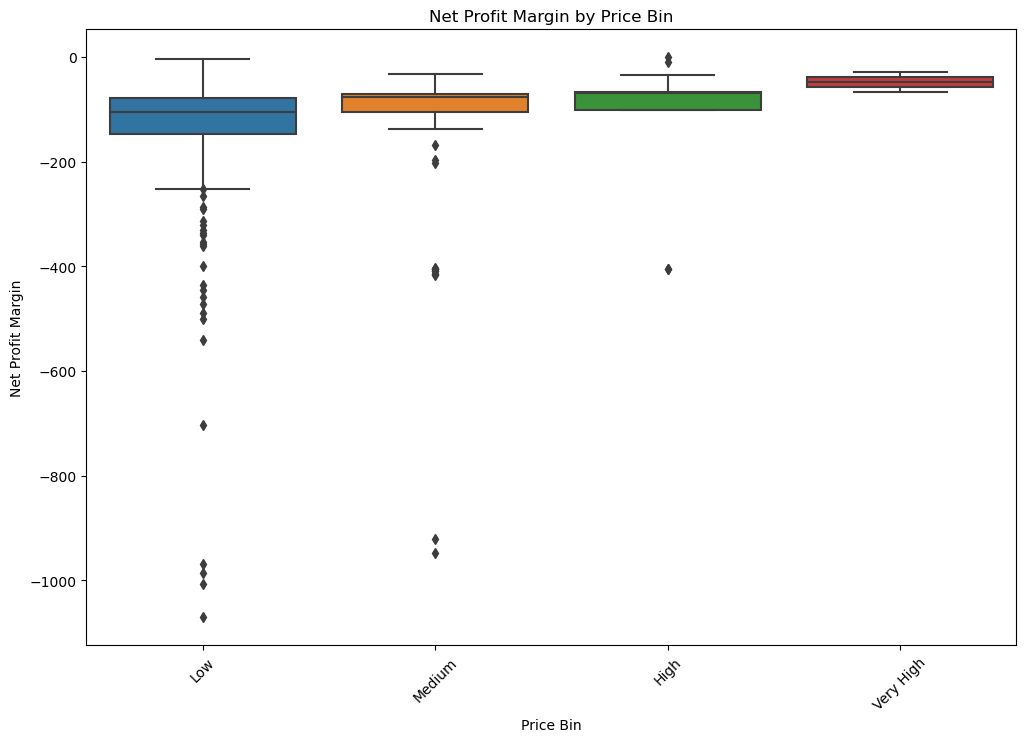

In [56]:
# Analyze net profit margin by product category
plt.figure(figsize=(12, 8))
sns.boxplot(x='price bin', y='net profit margin', data=non_zero_profit_margin)
plt.title('Net Profit Margin by Price Bin')
plt.xlabel('Price Bin')
plt.ylabel('Net Profit Margin')
plt.xticks(rotation=45)
plt.show()

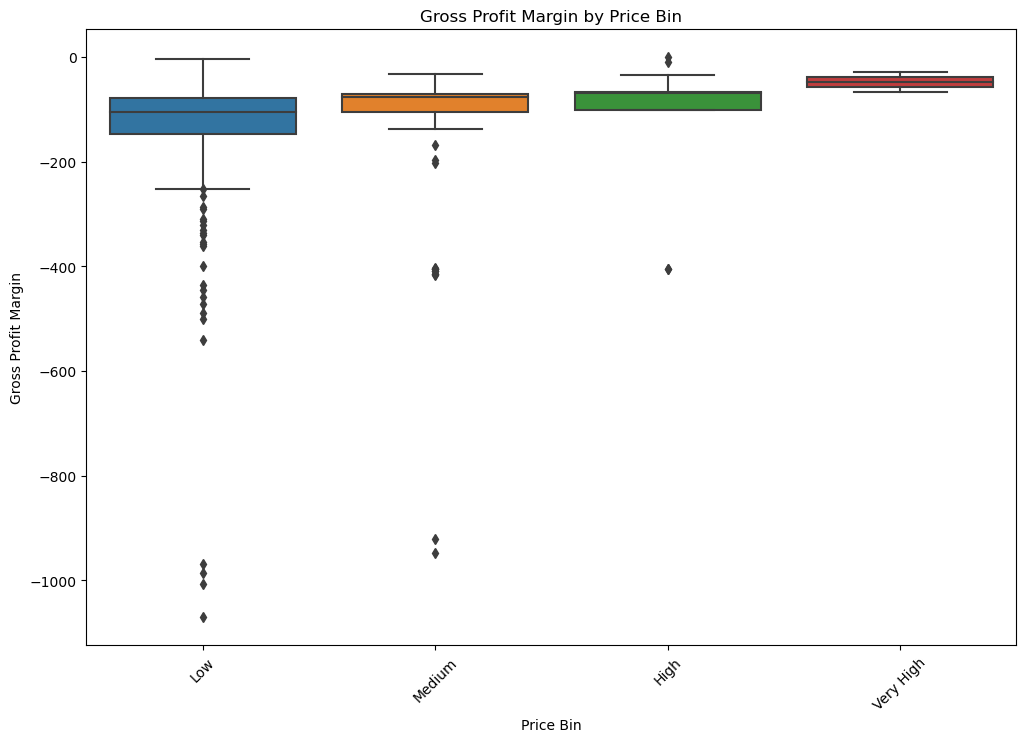

In [55]:
# Analyze gross profit margin by product category
plt.figure(figsize=(12, 8))
sns.boxplot(x='price bin', y='gross profit margin', data=non_zero_profit_margin)
plt.title('Gross Profit Margin by Price Bin')
plt.xlabel('Price Bin')
plt.ylabel('Gross Profit Margin')
plt.xticks(rotation=45)
plt.show()

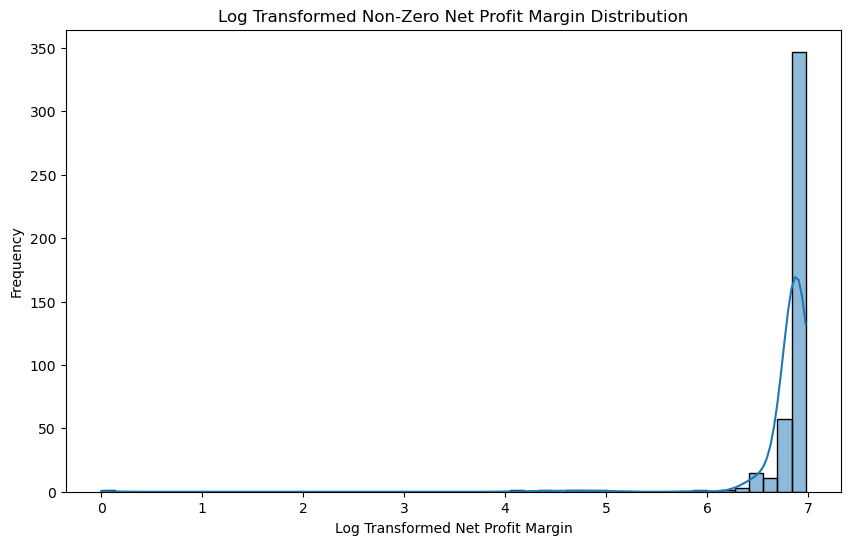

In [57]:
# Distribution Analysis with Log Transformation
plt.figure(figsize=(10, 6))
sns.histplot(np.log(non_zero_profit_margin['net profit margin'] - non_zero_profit_margin['net profit margin'].min() + 1), bins=50, kde=True)
plt.title('Log Transformed Non-Zero Net Profit Margin Distribution')
plt.xlabel('Log Transformed Net Profit Margin')
plt.ylabel('Frequency')
plt.show()

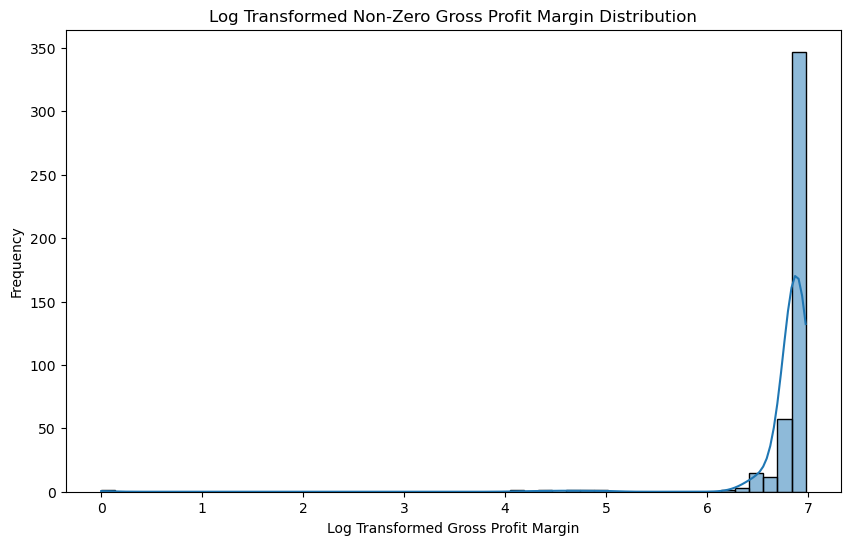

In [58]:
# Distribution Analysis with Log Transformation
plt.figure(figsize=(10, 6))
sns.histplot(np.log(non_zero_profit_margin['gross profit margin'] - non_zero_profit_margin['gross profit margin'].min() + 1), bins=50, kde=True)
plt.title('Log Transformed Non-Zero Gross Profit Margin Distribution')
plt.xlabel('Log Transformed Gross Profit Margin')
plt.ylabel('Frequency')
plt.show()

In [38]:
# Set option to see all columns
pd.set_option('display.max_columns', None)
df

,product title,original price,price,quantity sold,cost of shipping,total revenue,discount,discount percentage,gross profit,gross profit margin,net profit,net profit margin,product type,brand,original price bin,price bin,discount percentage bin,shipping cost bin,sales category,revenue per unit,cost per unit,profit category
0,Dresser For Bedroom With 9 Fabric Drawers Ward...,46.79,46.79,600,0.0,28074.00,0.00,0.000000,0.00,0.00000,0.00,0.00000,Dresser,Unknown,Low,Low,Low Discount,Low,High Sales,46.79,46.79,Loss
1,Outdoor Conversation Set 4 Pieces Patio Furnit...,169.72,169.72,0,0.0,0.00,0.00,0.000000,0.00,0.00000,0.00,0.00000,Chair,Unknown,Medium,Medium,Low Discount,Low,No Sales,0.00,0.00,Loss
2,Desser For Bedroom With 7 Fabric Drawers Organ...,78.40,39.46,7,0.0,276.22,38.94,49.668367,-272.58,-98.68221,-272.58,-98.68221,Bed,Unknown,Low,Low,High Discount,Low,Low Sales,39.46,78.40,Loss
3,"Modern Accent Boucle Chair,Upholstered Tufted ...",111.99,111.99,0,0.0,0.00,0.00,0.000000,0.00,0.00000,0.00,0.00000,Chair,Unknown,Medium,Medium,Low Discount,Low,No Sales,0.00,0.00,Loss
4,Small Unit Simple Computer Desk Household Wood...,48.82,21.37,1,0.0,21.37,27.45,56.226956,-27.45,-128.45110,-27.45,-128.45110,Table,Unknown,Low,Low,Very High Discount,Low,Low Sales,21.37,48.82,Loss
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1992,Oversized Outdoor Swivel Rocker Chairs Set wit...,555.46,555.46,0,0.0,0.00,0.00,0.000000,0.00,0.00000,0.00,0.00000,Chair,Unknown,High,High,Low Discount,Low,No Sales,0.00,0.00,Loss
1993,6pcs Patio Furniture Set PE Rattan Wicker Sect...,325.83,325.83,4,0.0,1303.32,0.00,0.000000,0.00,0.00000,0.00,0.00000,Table,Unknown,Medium,Medium,Low Discount,Low,Low Sales,325.83,325.83,Loss
1994,Garden Furniture 4507 (Dark Grey) Steel Frame ...,105.16,105.16,2,0.0,210.32,0.00,0.000000,0.00,0.00000,0.00,0.00000,Chair,Unknown,Medium,Medium,Low Discount,Low,Low Sales,105.16,105.16,Loss
1998,Furniture Acrylic Coffee Table Transparent Liv...,228.18,228.18,0,0.0,0.00,0.00,0.000000,0.00,0.00000,0.00,0.00000,Table,Unknown,Medium,Medium,Low Discount,Low,No Sales,0.00,0.00,Loss


In [59]:
print(os.getcwd())

C:\Users\Luisa


In [60]:
# Export datafram to a csv
df.to_csv('ecommerce_furniture.csv', index=False)